In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima_model import ARMA

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file = "D:\\matst\\sem6\\ZRP\\Data_ZRP.csv" 
df = pd.read_csv(file, parse_dates = ['Data'], index_col = 'Data')
df['Coal_pct'] = df.Coal.pct_change().mul(100) 
df.head()

,Coal,Natural_Gas,Coal_pct
Data,,,
2009-12-31,83.60,5.666,NaN
2010-01-04,88.65,5.720,6.040670
2010-01-05,93.00,5.783,4.906937
2010-01-06,93.30,5.638,0.322581
2010-01-07,96.65,5.941,3.590568


In [4]:
historic = df.Coal_pct.loc['2015':'2016'] 
actual = df.Coal_pct.loc['01-04-2017':]

In [5]:
data = df.Coal_pct.loc['2015':]

In [6]:
#parametric
def Par_Norm(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined parametric method with normal distribution
    """
    mean = data.mean()
    std = data.std()
    return(stats.norm.ppf(level, loc = mean, scale = std))
#historical
def Hist(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined historical method 
    """
    return(np.percentile(data.values, level*100))
#historical weighted
def His_weight(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined historical weighted method 
    """
    data = pd.DataFrame(data)
    N = len(data) - 1
    lda = 0.92
    S = lda*(1-lda**N)/(1-lda)
    w1 = 1/(1+S)
    data['weighted'] = w1*np.cumprod(np.concatenate([np.array([1]), lda*np.ones(N)]))[::-1]
    temp = data.sort_values('Coal_pct')
    temp['pr'] = temp['weighted'].cumsum()
    result = temp[temp['pr'] >= level].iloc[0]['Coal_pct']
    return(result)
#Monte Carlo
def mc(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined Monte Carlo method with MA(1)
    """
    model = ARMA(data.values, order = (0,1)).fit()
    mu, theta = model.params
    random_sample = np.random.normal(loc = np.mean(model.resid), scale = np.std(model.resid), size = 10000)
    predictions = mu + random_sample + theta*model.resid[-1]
    return np.percentile(predictions, level*100)

In [38]:
def Var_vector(data, Varfunction, alpha, year = 2, beg_index = 0):
    """ 
    input
    data: vector of portfolio returns
    Varfunction: function determining value at risk 
    alpha: statistical significance
    output
    var_vector: forecast of VaR for each day
    data[2*year:] : actual value of portfolio returns
    """ 
    data_len = len(data) 
    var_len = data_len-year*365-beg_index #range - 2 years
    var_vector = np.empty(var_len, float)
    for i in range(var_len): 
        var_vector[i] = Varfunction( data[beg_index+i : (year*365+i)], (1-alpha) )
    return(var_vector, data[beg_index+year*365:])
        
    

In [26]:
def Backtesting(actual, forecast, alpha, model=None, test="Christoffersen"):
    """ 
    input
    actual: portfolio returns
    forecast: Value at risk -dictionary or scalar
    alpha: statistical significance
    output:
    dataframe: columns: model, Statistic, alpha,  p-value, test outcome 
    """
    results = []
    if type(forecast) == dict:
        for key in forecast:
            I = (actual > forecast[key])*1
            con = I[1:]-I[:-1] 
            n01, n10 = (con == 1).sum(), (con == -1).sum() 
            n11, n00 = (I[1:][con == 0] == 1).sum(), (I[1:][con == 0] == 0).sum()
            p0 = n01/(n00 + n01)         
            p1 = n11/(n10 + n11)
            p = (n01 + n11)/(n00 + n01 + n10 + n11)
            # indepedence Christoffersen
            if test == "Christoffersen":
                LR = -2*np.log((1 - p)**(n00+n10)*p**(n01 + n11)/((1-p0)**(n00)*p0**n01*(1-p1)**n10*p1**n11))
                chi = 1 - stats.chi2.cdf(LR,  df=1)
                if chi < alpha:
                    ans = "reject"
                else:
                    ans = "accept"
            #kupiec
            if test == "Kupiec":
                i = I.sum()
                proc = i/len(I)
                Lpi = (1-i/len(I))**(len(I)-i)*(i/len(I))**i
                pk = alpha
                Lp = (1-pk)**(len(I)-i)*pk**i
                LR = -2*np.log(Lp/Lpi)
                chi = 1 - stats.chi2.cdf(LR,df=1)

                if chi< alpha:
                    ans = "reject"
                else:
                    ans = "accept"
            frame = {"Model": key,"alpha": alpha, "Statistic": LR, "p-value": chi, "result": ans, "percentage of exceedances":str(p*100)+"%"}
            results.append(frame)
            
    else:
        I = (actual > forecast)*1 
        con = I[1:]-I[:-1] 
        n01, n10 = (con == 1).sum(), (con == -1).sum() 
        n11, n00 = (I[1:][con == 0] == 1).sum(), (I[1:][con == 0] == 0).sum()
        p0 = n01/(n00 + n01)         
        p1 = n11/(n10 + n11)
        p = (n01 + n11)/(n00 + n01 + n10 + n11)
        LR = -2*np.log((1 - p)**(n00+n10)*p**(n01 + n11)/((1-p0)**(n00)*p0**n01*(1-p1)**n10*p1**n11))
        chi = 1 - stats.chi2.cdf(LR,  df=1)
        
        if chi < alpha:
            ans = "reject"
        else:
            ans = "accept"
        if model is not None:
            name = model
        else:
            name = " - "
        results = {"Model": [name],"alpha": [alpha],"Statistic": [LR], "p-value": [chi], "result": [ans], "percentage of exceedances":[str(p*100)]}
    results = pd.DataFrame(data=results)
    return (results)

In [35]:
Pvar5, days = Var_vector(data, Par_Norm ,0.05)
Hvar5, Hdays =  Var_vector(data, Hist ,0.05)
HWvar5, HWdays = Var_vector(data, His_weight ,0.05)
Mvar5, Mdays = Var_vector(data, mc ,0.05)

forecast5 = {"parametric": Pvar5, "historical": Hvar5,"historical weighted": HWvar5,"Monte Carlo": Mvar5}
Backtesting(days.values, forecast5, 0.05, test="Christoffersen")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,0.011652,0.05,0.914041,7.941176470588235%,accept
1,Monte Carlo,0.149259,0.05,0.699244,1.4705882352941175%,accept
2,historical,0.149259,0.05,0.699244,1.4705882352941175%,accept
3,parametric,0.149259,0.05,0.699244,1.4705882352941175%,accept


In [36]:
Backtesting(days.values, forecast5, 0.05, test="Kupiec")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,5.231868,0.05,0.022177,7.941176470588235%,reject
1,Monte Carlo,12.275646,0.05,0.000459,1.4705882352941175%,reject
2,historical,12.275646,0.05,0.000459,1.4705882352941175%,reject
3,parametric,12.275646,0.05,0.000459,1.4705882352941175%,reject


In [30]:
Pvar9, Pdays = Var_vector(data, Par_Norm ,0.01)
Hvar9, Hdays =  Var_vector(data, Hist ,0.01)
HWvar9, HWdays = Var_vector(data, His_weight ,0.01)
Mvar9, Mdays = Var_vector(data, mc ,0.01)
forecast9= {"parametric": Pvar9, "historical": Hvar9,"historical weighted": HWvar9, "Monte Carlo":Mvar9}
Backtesting(days.values, forecast9, 0.01, test="Christoffersen")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,0.624763,0.01,0.429283,3.5294117647058822%,accept
1,Monte Carlo,0.005900,0.01,0.938775,0.29411764705882354%,accept
2,historical,0.005900,0.01,0.938775,0.29411764705882354%,accept
3,parametric,0.005900,0.01,0.938775,0.29411764705882354%,accept


In [31]:
Backtesting(days.values, forecast9, 0.01, test="Kupiec")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,13.237116,0.01,0.000274,3.5294117647058822%,reject
1,Monte Carlo,2.383739,0.01,0.122604,0.29411764705882354%,accept
2,historical,2.383739,0.01,0.122604,0.29411764705882354%,accept
3,parametric,2.383739,0.01,0.122604,0.29411764705882354%,accept


Przesunięcie okna 

In [39]:
Pvar5_mov, days_mov = Var_vector(data, Par_Norm ,0.05, year =1 , beg_index = 200)
Hvar5_mov, Hdays_mov =  Var_vector(data, Hist ,0.05, year =1 , beg_index = 200)
HWvar5_mov, HWdays_mov = Var_vector(data, His_weight ,0.05, year =1 , beg_index = 200)
Mvar5_mov, Mdays_mov = Var_vector(data, mc ,0.05, year =1 , beg_index = 200)

forecast5_mov = {"parametric": Pvar5_mov, "historical": Hvar5_mov,"historical weighted": HWvar5_mov,"Monte Carlo": Mvar5_mov}
Backtesting(days_mov.values, forecast5_mov, 0.05, test="Christoffersen")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,2.401148,0.05,0.121246,5.9405940594059405%,accept
1,Monte Carlo,0.918511,0.05,0.337866,2.9702970297029703%,accept
2,historical,1.184666,0.05,0.276408,3.3663366336633667%,accept
3,parametric,0.798479,0.05,0.371549,2.7722772277227725%,accept


In [40]:
Backtesting(days_mov.values, forecast5_mov, 0.05, test="Kupiec")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,0.869683,0.05,0.351043,5.9405940594059405%,accept
1,Monte Carlo,5.136514,0.05,0.023428,2.9702970297029703%,reject
2,historical,3.224398,0.05,0.072548,3.3663366336633667%,accept
3,parametric,6.294658,0.05,0.012110,2.7722772277227725%,reject


In [42]:
Pvar9_mov, days_mov = Var_vector(data, Par_Norm ,0.01, year =1 , beg_index = 200)
Hvar9_mov, Hdays_mov =  Var_vector(data, Hist ,0.01, year =1 , beg_index = 200)
HWvar9_mov, HWdays_mov = Var_vector(data, His_weight ,0.01, year =1 , beg_index = 200)
Mvar9_mov, Mdays_mov = Var_vector(data, mc ,0.01, year =1 , beg_index = 200)

forecast9_mov = {"parametric": Pvar9_mov, "historical": Hvar9_mov,"historical weighted": HWvar9_mov,"Monte Carlo": Mvar9_mov}
Backtesting(days_mov.values, forecast9_mov, 0.01, test="Christoffersen")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,0.489919,0.01,0.483963,2.178217821782178%,accept
1,Monte Carlo,0.100002,0.01,0.751828,0.9900990099009901%,accept
2,historical,0.035857,0.01,0.849812,0.594059405940594%,accept
3,parametric,0.063873,0.01,0.800476,0.7920792079207921%,accept


In [43]:
Backtesting(days_mov.values, forecast9_mov, 0.01, test="Kupiec")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,historical weighted,5.274348,0.01,0.021642,2.178217821782178%,accept
1,Monte Carlo,0.000721,0.01,0.978571,0.9900990099009901%,accept
2,historical,0.991935,0.01,0.319270,0.594059405940594%,accept
3,parametric,0.241664,0.01,0.623007,0.7920792079207921%,accept


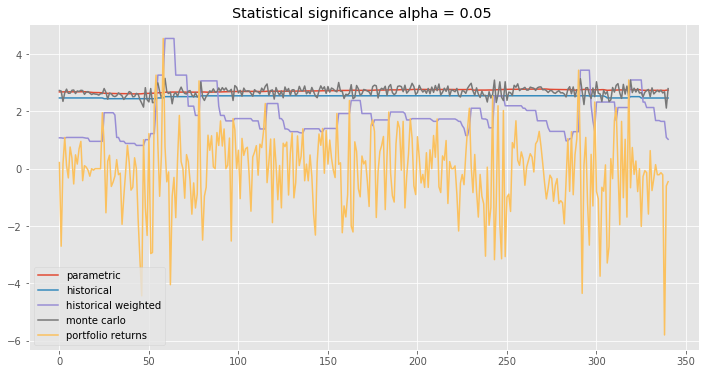

In [14]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(Pvar5, label = "parametric")
plt.plot(Hvar5, label = "historical")
plt.plot(HWvar5, label = "historical weighted")
plt.plot(Mvar5, label = "monte carlo")
plt.plot(days.values, label = "portfolio returns" )
plt.legend(loc = 3)
plt.title("Statistical significance alpha = 0.05 ")
plt.show()

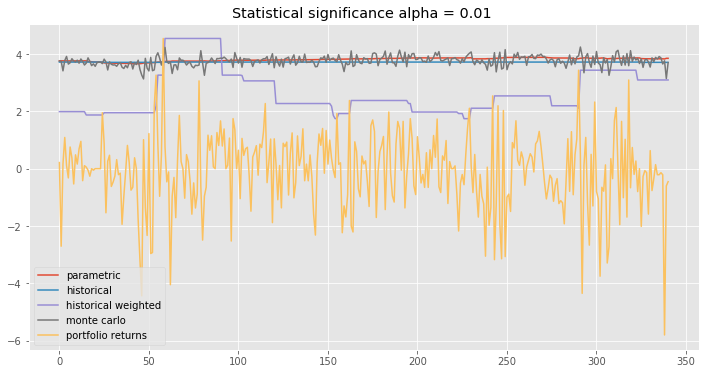

In [31]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(Pvar9, label = "parametric")
plt.plot(Hvar9, label = "historical")
plt.plot(HWvar9, label = "historical weighted")
plt.plot(Mvar9, label = "monte carlo")
plt.plot(days.values, label = "portfolio returns" )
plt.legend(loc = 3)
plt.title("Statistical significance alpha = 0.01 ")
plt.show()